<h1 style='color:blue'><center> Brain Tumor Detection<center></h1>

<h4 style='color:royalblue'><span style='color:red'>Task : </span>Identify tumors in the MRI images.<br>

<span style='color:red'>Method : </span> We will use CNN architecture to solve the given task as well as Transfer Learning to increase the accuracy of our model</h4>


<h1 style='color:orange'>Importing Libraries</h1>

In [1]:
import os
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
from random import choices
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout

<h1 style='color:orange'>Data Wrangling</h1>

In [2]:
input_path='../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
for file in os.listdir(input_path):
    print(file)

no
yes


**Let's visualize the total number of labels of each type in data**

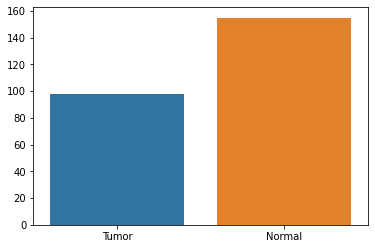

In [3]:
type1=len(os.listdir(input_path+'/no'))
type2=len(os.listdir(input_path+'/yes'))

count=[type1,type2]
label=['Tumor','Normal']

sns.barplot(label,count)

In [4]:
def show_image(folder):
    path=os.path.join(input_path,folder)
    
    images=choices(os.listdir(path),k=4)
    images=[os.path.join(path,file) for file in images]
    
    return images

**Let's see how the MRI scan of each type looks. We would be using open cv library to read and show the image.**

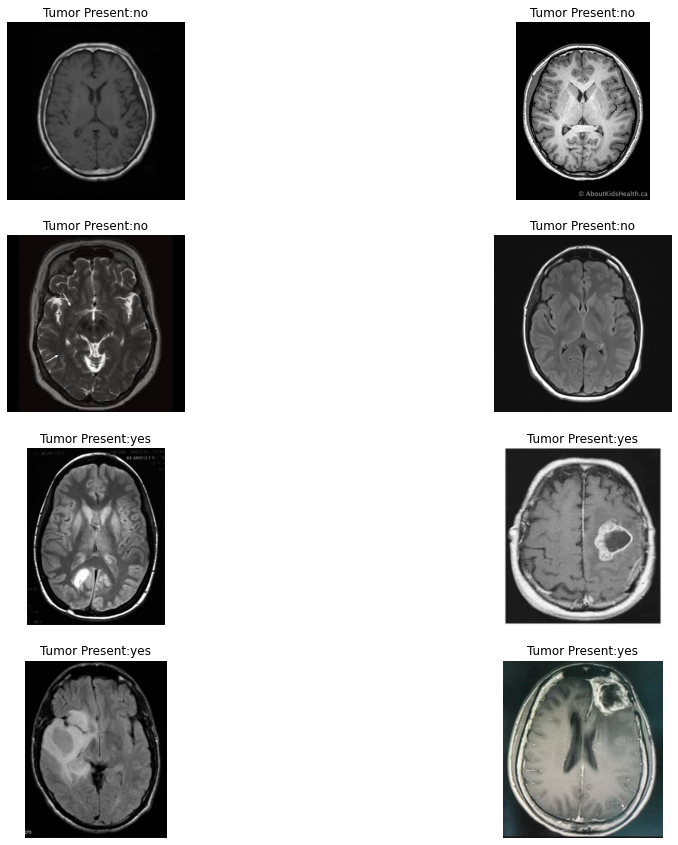

In [5]:
img1=show_image('no')
img2=show_image('yes')
label1=['no']*4
label2=['yes']*4

images=img1+img2
labels=label1+label2

plt.figure(figsize=(16,15))

for i,path_name in enumerate(images):
    plt.subplot(4,2,i+1)
    image=cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present:"+labels[i])
    plt.axis('off')

<h1 style='color:orange'> Model Building</h1>

<h2>Image Augmentation </h2>

**We will use Image Augmentation to train the model on different types of combination formed by rotation ,flipping of image so as to increase our model accuracy**

In [6]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2
                            )

train_gen= datagen.flow_from_directory(input_path,
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( input_path,
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


<h4><span style='color:red'>Note:</span> In this task a custom made model isn't able to get past over 78-80% accuracy also the loss and accuracy curves are not smooth so we will be using VGG16 model i.e Transfer Learning to increase our accuracy.</h4>

In [7]:
vgg_model=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)
model=keras.Sequential()
for layer in vgg_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False

58892288/58889256 [==============================] - 0s 0us/step


**We will add dropout and other dense layers to avoid overfitting and make the model more robust.**

In [8]:
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

**We would use callbacks like Early Stopping and Model Check Point to save the model on the epoch having the best validation accuracy and to stop the model if the model isn't doing better on validation accuracy.**

In [10]:
stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history=model.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=[stop,checkpoint])

Epoch 1/30
7/7 [==============================] - 5s 756ms/step - loss: 2.5278 - accuracy: 0.5517 - val_loss: 1.0490 - val_accuracy: 0.3800
Epoch 2/30
7/7 [==============================] - 4s 529ms/step - loss: 0.6767 - accuracy: 0.6404 - val_loss: 0.6023 - val_accuracy: 0.6800
Epoch 3/30
7/7 [==============================] - 4s 527ms/step - loss: 0.5859 - accuracy: 0.7094 - val_loss: 0.6075 - val_accuracy: 0.6800
Epoch 4/30
7/7 [==============================] - 4s 530ms/step - loss: 0.4515 - accuracy: 0.8177 - val_loss: 0.5215 - val_accuracy: 0.7600
Epoch 5/30
7/7 [==============================] - 4s 561ms/step - loss: 0.4134 - accuracy: 0.8227 - val_loss: 0.4602 - val_accuracy: 0.7800
Epoch 6/30
7/7 [==============================] - 4s 534ms/step - loss: 0.3816 - accuracy: 0.8374 - val_loss: 0.4554 - val_accuracy: 0.7800
Epoch 7/30
7/7 [==============================] - 3s 480ms/step - loss: 0.3609 - accuracy: 0.8670 - val_loss: 0.4865 - val_accuracy: 0.7400
Epoch 8/30
7/7 [====

<h2 style='color:orange'>Model Performance</h2>

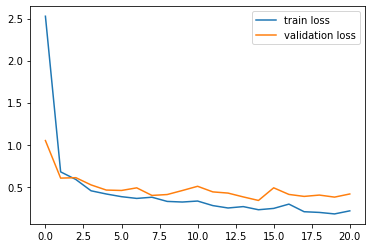

In [11]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

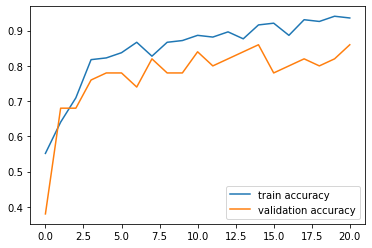

In [12]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

<h4><span style='color:red'>Note : </span>The Dataset used in the task has only 253 images which is far from enough for the model to train and hence has less accuracy.Increasing the size of dataset can increase the model performance and thus solving the problem</h4>